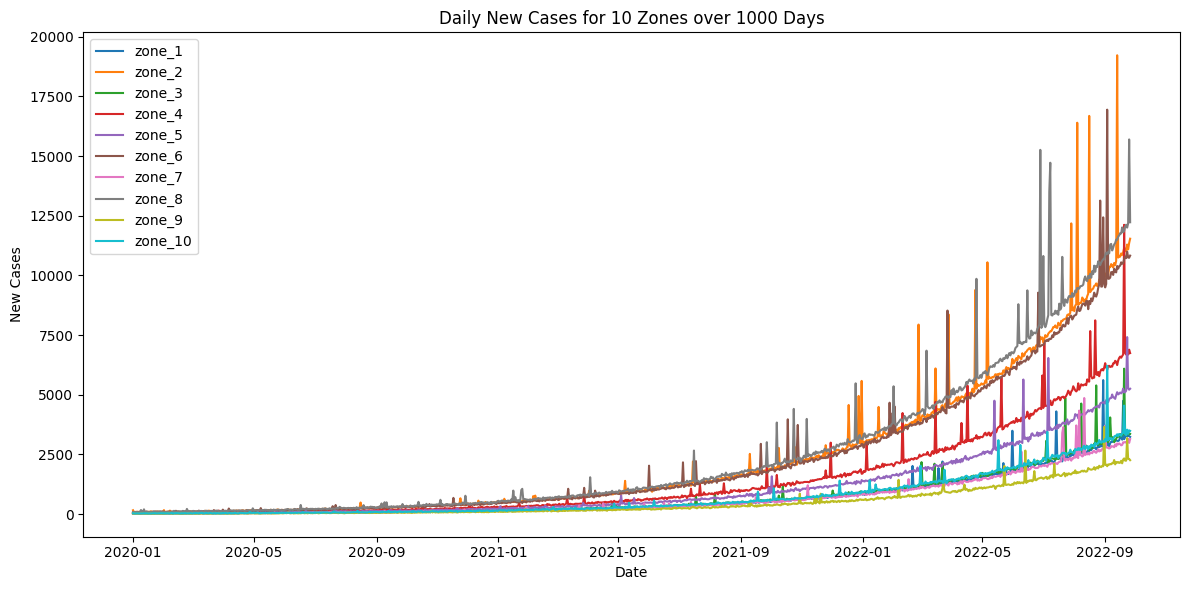

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Parameters
num_zones = 10
days = 1000
start_date = datetime(2020, 1, 1)
base_rate = 10
growth_rate = 0.005
pop_min = 100000
pop_max = 1000000

# Reduced spike settings
spike_prob = 0.03  # lower probability of a spike
spike_multiplier_low = 1.2  # lower bound of spike multiplier
spike_multiplier_high = 2.0  # upper bound of spike multiplier

seed = 42

# Generate zone populations
np.random.seed(seed)
populations = {f'zone_{i+1}': int(p) for i, p in enumerate(
    np.random.randint(pop_min, pop_max+1, size=num_zones)
)}

# Simulate data
records = []
for day in range(days):
    date = start_date + timedelta(days=day)
    baseline = base_rate * np.exp(growth_rate * day)
    for zone, pop in populations.items():
        expected = baseline * (pop / 100000)
        cases = np.random.poisson(expected)
        if np.random.rand() < spike_prob:
            cases = int(cases * np.random.uniform(spike_multiplier_low, spike_multiplier_high))
        records.append({'date': date, 'zone': zone, 'new_cases': cases})

df = pd.DataFrame(records)

# Plot
plt.figure(figsize=(12, 6))
for zone in populations.keys():
    subset = df[df['zone'] == zone]
    plt.plot(subset['date'], subset['new_cases'], label=zone)
plt.xlabel('Date')
plt.ylabel('New Cases')
plt.title('Daily New Cases for 10 Zones over 1000 Days')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
import json
import random

# Generate params.json with only populations for 10 zones
zones = [f"zone_{i}" for i in range(1, 11)]
# Create populations from ~70k down to ~30k
pops = sorted(random.sample(range(30000, 70001), 10), reverse=True)

params = {zone: {"population": pop} for zone, pop in zip(zones, pops)}

# Save to file
file_path = 'params.json'
with open(file_path, 'w') as f:
    json.dump(params, f, indent=2)

# Display resulting JSON
print(json.dumps(params, indent=2))

{
  "zone_1": {
    "population": 66553
  },
  "zone_2": {
    "population": 61071
  },
  "zone_3": {
    "population": 60246
  },
  "zone_4": {
    "population": 56161
  },
  "zone_5": {
    "population": 54180
  },
  "zone_6": {
    "population": 52388
  },
  "zone_7": {
    "population": 49700
  },
  "zone_8": {
    "population": 38458
  },
  "zone_9": {
    "population": 34664
  },
  "zone_10": {
    "population": 31523
  }
}


In [18]:
df.to_csv('data.csv', index=False)

In [19]:
import os
import io
import json
import logging
from typing import Dict, Tuple

import numpy as np
import pandas as pd
from scipy.integrate import odeint

# ─── Logging Configuration ───────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)


# ─── Persistence Layer ───────────────────────────────────────────────────────────
class ParameterStore:
    """
    JSON‑backed store for per‑zone parameters and recent counts.
    """
    def __init__(self, filepath: str = 'params.json') -> None:
        self.filepath = filepath
        self._params = self._load()

    def _load(self) -> Dict[str, Dict]:
        if os.path.exists(self.filepath):
            try:
                with open(self.filepath, 'r') as f:
                    return json.load(f) or {}
            except (json.JSONDecodeError, ValueError):
                logging.warning(f"Malformed params at {self.filepath}, resetting store.")
        return {}

    def get_params(self, key: str) -> Dict:
        return self._params.get(key, {})

    def set_params(self, key: str, params: Dict) -> None:
        self._params[key] = params

    def save(self) -> None:
        def _convert(o):
            if isinstance(o, (np.integer, np.floating)):
                return o.item()
            if isinstance(o, np.ndarray):
                return o.tolist()
            raise TypeError(f"Type {type(o)} not serializable")

        with open(self.filepath, 'w') as f:
            json.dump(self._params, f, default=_convert, indent=2)
        logging.info(f"Parameters persisted to {self.filepath}")


# ─── Core SEIR Model ────────────────────────────────────────────────────────────
class SEIRModel:
    def __init__(self, beta: float, sigma: float, gamma: float, population: int) -> None:
        self.beta = beta
        self.sigma = sigma
        self.gamma = gamma
        self.population = population

    @staticmethod
    def _derivatives(state, t, beta, sigma, gamma, pop):
        S, E, I, R = state
        dS = -beta * S * I / pop
        dE = beta * S * I / pop - sigma * E
        dI = sigma * E - gamma * I
        dR = gamma * I
        return dS, dE, dI, dR

    def simulate(self, init: Tuple[int,int,int,int], days: int) -> np.ndarray:
        t = np.arange(days + 1)
        sol = odeint(
            self._derivatives, init, t,
            args=(self.beta, self.sigma, self.gamma, self.population)
        )
        return sol[:, 2].astype(int)  # infected compartment


# ─── Forecast & Detection Engine ────────────────────────────────────────────────
class ForecastEngine:
    def __init__(self, model: SEIRModel) -> None:
        self.model = model

    def detect_outbreak(self, recent: pd.Series, zscore_thresh: float) -> bool:
        if len(recent) < 2:
            return False
        window = recent.iloc[-7:]
        if window.std() == 0:
            return False
        z = (recent.iloc[-1] - window.mean()) / window.std()
        return bool(z > zscore_thresh)

    def detect_epidemic(self, forecast: np.ndarray, frac_thresh: float) -> bool:
        return bool(forecast.max() / self.model.population > frac_thresh)

    def needs_recalibration(
        self, observed: np.ndarray, predicted: np.ndarray, err_thresh: float
    ) -> bool:
        err = np.mean(np.abs(observed - predicted[:len(observed)]))
        return err > err_thresh

    def calibrate(self, observed: np.ndarray, params: Dict) -> Dict:
        updated = params.copy()
        updated['beta'] *= 1.01
        logging.info("Recalibration: beta increased by 1%.")
        return updated

    def forecast(
        self,
        recent: pd.Series,
        init: Tuple[int,int,int,int],
        horizon: int,
        params: Dict
    ) -> Dict:
        # 1) Check if we need to recalibrate based on recent history
        baseline = self.model.simulate(init, days=len(recent)-1)
        if self.needs_recalibration(
            observed=recent.values,
            predicted=baseline,
            err_thresh=params['calibration_error_threshold']
        ):
            params = self.calibrate(recent.values, params)

        # 2) Final horizon forecast
        fcast = self.model.simulate(init, days=horizon)

        return {
            'updated_params': params,
            'forecast': fcast.tolist(),
            'outbreak': self.detect_outbreak(recent, params['outbreak_zscore']),
            'epidemic': self.detect_epidemic(fcast, params['epidemic_fraction'])
        }


# ─── Incremental Pipeline ───────────────────────────────────────────────────────
class OutbreakForecastPipeline:
    """
    1) `run()` seeds your store with historical calibrations.
    2) `update_today_data()` ingests today's batch only.
    """
    def __init__(
        self,
        data_path: str,
        default_population: int = 100_000,
        params_path: str = 'params.json'
    ) -> None:
        self.data_path = data_path
        self.default_population = default_population
        self.param_store = ParameterStore(params_path)

    def run(self, forecast_horizon: int = 14) -> Dict[str, object]:
        """
        One‑time full ingestion of your CSV/JSON history. Populates:
         - model parameters
         - a rolling buffer `recent_counts` per location
        """
        df = pd.read_csv(self.data_path, parse_dates=['date'])
        df = df.rename(columns={'zone': 'location', 'new_cases': 'count'})

        results: Dict[str, object] = {}
        for loc, grp in df.groupby('location'):
            grp = grp.sort_values('date')
            counts = grp['count'].astype(int)
            pop = int(grp.get('population', pd.Series([self.default_population])).iloc[0])

            # Default params + stored overrides
            stored = self.param_store.get_params(loc)
            params = {
                'beta': 0.3,
                'sigma': 1/5.2,
                'gamma': 1/2.9,
                'population': pop,
                'outbreak_zscore': 2.0,
                'epidemic_fraction': 0.01,
                'calibration_error_threshold': 50,
                'last_R': stored.get('last_R', 0),
                **stored
            }

            # Seed recent_counts buffer
            params['recent_counts'] = counts.iloc[-7:].tolist()
            params['last_I'] = counts.iloc[-1]
            params['last_E'] = counts.iloc[-1]

            # Initial forecast & store bump
            model = SEIRModel(params['beta'], params['sigma'], params['gamma'], pop)
            engine = ForecastEngine(model)
            init = (
                pop - params['last_E'] - params['last_I'] - params['last_R'],
                params['last_E'],
                params['last_I'],
                params['last_R']
            )
            out = engine.forecast(pd.Series(params['recent_counts']), init, forecast_horizon, params)

            self.param_store.set_params(loc, out['updated_params'])
            results[loc] = {
                'forecast': out['forecast'],
                'outbreak': out['outbreak'],
                'epidemic': out['epidemic']
            }

        self.param_store.save()
        return results

    def update_today_data(
        self,
        today_json: str,
        forecast_horizon: int = 14,
        window: int = 7
    ) -> Dict[str, object]:
        """
        Ingests *only* today's JSON batch (10 rows), updates your rolling buffer,
        recalibrates if needed, and emits an up‑to‑the‑minute forecast—no full retrain.
        """
        today_df = pd.read_json(io.StringIO(today_json), orient='records')
        today_df = today_df.rename(columns={'zone': 'location', 'new_cases': 'count'})
        today_df['date'] = pd.to_datetime(today_df['date'])

        results: Dict[str, object] = {}
        for loc, group in today_df.groupby('location'):
            # We assume one row per loc – if multiple, sum them:
            todays_count = int(group['count'].sum())

            stored = self.param_store.get_params(loc)
            pop = stored.get('population', self.default_population)

            # Bootstrap defaults on first‑time ingestion
            if not stored:
                stored = {
                    'beta': 0.3,
                    'sigma': 1/5.2,
                    'gamma': 1/2.9,
                    'population': pop,
                    'outbreak_zscore': 2.0,
                    'epidemic_fraction': 0.01,
                    'calibration_error_threshold': 50,
                    'last_R': 0,
                    'recent_counts': []
                }

            # Update rolling window
            recent = stored.get('recent_counts', [])
            recent.append(todays_count)
            recent = recent[-window:]

            # Prepare forecast
            params = {**stored, 'recent_counts': recent, 'last_I': todays_count, 'last_E': todays_count}
            model = SEIRModel(params['beta'], params['sigma'], params['gamma'], pop)
            engine = ForecastEngine(model)
            init_state = (
                pop - params['last_E'] - params['last_I'] - params['last_R'],
                params['last_E'],
                params['last_I'],
                params['last_R']
            )
            out = engine.forecast(pd.Series(recent), init_state, forecast_horizon, params)

            # Persist back
            self.param_store.set_params(loc, out['updated_params'])
            results[loc] = {
                'forecast': out['forecast'],
                'outbreak': out['outbreak'],
                'epidemic': out['epidemic']
            }

        self.param_store.save()
        return results

    def predict_forecast(
        self,
        forecast_horizon: int = 14,
        window: int = 7
    ) -> Dict[str, object]:
        """
        Produce an up‑to‑date forecast for every location in the parameter store,
        leveraging the stored recent_counts buffer—no new data ingestion required.
        """
        results: Dict[str, object] = {}
        for loc, stored in self.param_store._params.items():
            # 1) Retrieve stored params & build rolling window
            params = stored.copy()
            recent = params.get('recent_counts', [])[-window:]
            params['recent_counts'] = recent

            # 2) Derive init state from last known E, I, R
            pop   = params['population']
            last_E = params.get('last_E', recent[-1] if recent else 0)
            last_I = params.get('last_I', recent[-1] if recent else 0)
            last_R = params.get('last_R', 0)
            init_state = (
                pop - last_E - last_I - last_R,
                last_E,
                last_I,
                last_R
            )

            # 3) Drive the SEIR forecast engine
            model  = SEIRModel(params['beta'], params['sigma'], params['gamma'], pop)
            engine = ForecastEngine(model)
            out    = engine.forecast(pd.Series(recent), init_state, forecast_horizon, params)

            # 4) Collate without persisting
            results[loc] = {
                'forecast': out['forecast'],
                'outbreak': out['outbreak'],
                'epidemic': out['epidemic']
            }

        return results


In [12]:

# # ─── Usage Example ───────────────────────────────────────────────────────────────
# if __name__ == '__main__':
#     # 1) One‑time seed with full history
#     pipeline = OutbreakForecastPipeline(
#         data_path='data.csv',
#         default_population=100_000,
#         params_path='params.json'
#     )
#     initial = pipeline.run(forecast_horizon=14)
#     # print("Initial seeding complete:", json.dumps(initial, indent=2))

#     forecast = pipeline.predict_forecast()
#     print("Daily forecast:", json.dumps(forecast, indent=2))

#     # 2) Daily incremental update with inline JSON payload
    # today_payload = '''[
    #   { "zone": "zone_1",  "date": "2025-06-12", "new_cases": 3245 },
    #   { "zone": "zone_2",  "date": "2025-06-12", "new_cases": 3387 },
    #   { "zone": "zone_3",  "date": "2025-06-12", "new_cases": 11573 },
    #   { "zone": "zone_4",  "date": "2025-06-12", "new_cases": 3420 },
    #   { "zone": "zone_5",  "date": "2025-06-12", "new_cases": 6862 },
    #   { "zone": "zone_6",  "date": "2025-06-12", "new_cases": 5915 },
    #   { "zone": "zone_7",  "date": "2025-06-12", "new_cases": 10934 },
    #   { "zone": "zone_8",  "date": "2025-06-12", "new_cases": 2798 },
    #   { "zone": "zone_9",  "date": "2025-06-12", "new_cases": 13881 },
    #   { "zone": "zone_10", "date": "2025-06-12", "new_cases": 3327 }
    # ]'''

#     # updated = pipeline.update_today_data(
#     #     today_json=today_payload,
#     #     forecast_horizon=14
#     # )
#     # print("Daily incremental update:", json.dumps(updated, indent=2))

In [ ]:
from flask import Flask, jsonify, request
from flask_cors import CORS

app = Flask(__name__)
CORS(app, resources={r"/*": {"origins": "*"}})

pipeline = OutbreakForecastPipeline(
    data_path='data.csv',
    default_population=100_000,
    params_path='params.json'
)
initial = pipeline.run(forecast_horizon=14)
params = pipeline.param_store._params

@app.route('/prediction', methods=['GET'])
def home():
    forecast = pipeline.predict_forecast()
    res = {}
    res['data'] = []
    for zone, data in forecast.items():
        res['data'].append({
            'zone': zone,
            'forecast': data['forecast'],
            'outbreak': data['outbreak'],
            'epidemic': data['epidemic'],
            'population': params[zone]['population']
        })
    return jsonify(res)

@app.route('/zonePrediction/<zone>', methods=['GET'])
def zone_prediction(zone):
    if zone not in params:
        return jsonify({'error': 'Zone not found'}), 404
    forecast = pipeline.predict_forecast()
    if zone not in forecast:
        return jsonify({'error': 'No forecast data for this zone'}), 404
    data = forecast[zone]
    return jsonify({
        'zone': zone,
        'forecast': data['forecast'],
        'outbreak': data['outbreak'],
        'epidemic': data['epidemic'],
        'population': params[zone]['population']
    })

@app.route('/feedTodayData', methods=['POST'])
def feed_today_data():
    # Example payload: [{"zone": "zone_1", "date": "2025-06-12", "new_cases": 3245}, ...]
    if not request.is_json:
        return jsonify({'error': 'Invalid JSON payload'}), 400

    today_data = request.get_json()

    try:
        updated = pipeline.update_today_data(
            today_json=json.dumps(today_data['data']),
            forecast_horizon=14
        )
        return jsonify(updated)
    except Exception as e:
        return jsonify({'error': str(e)}), 500

if __name__ == '__main__':
    app.run(debug=False, use_reloader=False)

2025-06-12 16:53:17,130 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,137 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,141 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,144 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,147 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,150 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,155 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,159 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,164 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,171 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:17,178 - INFO - Parameters persisted to params.json


 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
2025-06-12 16:53:17,205 - INFO - WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
2025-06-12 16:53:17,208 - INFO - Press CTRL+C to quit
2025-06-12 16:53:26,377 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:26,390 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:26,393 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:26,395 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:26,399 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:26,401 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:26,404 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:26,406 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:26,411 - INFO - Recalibration: beta increased by 1%.
2025-06-12 16:53:26,420 - INFO - Recalibration: beta increased by 1%.
1